## Data Engineering Capstone Project

### Project Summary
This project 

The project involves the following steps:
- Step 1: Scope the Project and Gather Data
- Step 2: Explore and Assess the Data
- Step 3: Define the Data Model
- Step 4: Run ETL to Model the Data
- Step 5: Complete Project Write Up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from datetime import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import concat, lit, col , avg , desc , expr

### Step 1: Scope the Project and Gather Data
#### Scope 
The scope of the project is to analyse the US immigration data across different cities and its relation with the characteristics of a city w.r.t the population and the weather.


#### Describe and Gather Data 
The main dataset includes data on immigration to the United States, and supplementary datasets will include data on airport codes, U.S. city demographics, and temperature data.

##### The US immigration data

In [2]:
path = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df = pd.read_sas(path, 'sas7bdat', encoding="ISO-8859-1")

In [3]:
df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [2]:
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

In [5]:
df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat')

In [6]:
#write to parquet
df_spark.write.parquet("sas_data")
df_spark=spark.read.parquet("sas_data")

In [7]:
df_spark.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [8]:
df_spark.take(1)

[Row(cicid=5748517.0, i94yr=2016.0, i94mon=4.0, i94cit=245.0, i94res=438.0, i94port='LOS', arrdate=20574.0, i94mode=1.0, i94addr='CA', depdate=20582.0, i94bir=40.0, i94visa=1.0, count=1.0, dtadfile='20160430', visapost='SYD', occup=None, entdepa='G', entdepd='O', entdepu=None, matflag='M', biryear=1976.0, dtaddto='10292016', gender='F', insnum=None, airline='QF', admnum=94953870030.0, fltno='00011', visatype='B1')]

#### The US cities demographics data

In [9]:
path_cities = "us-cities-demographics.csv"
df_cities= pd.read_csv(path_cities, delimiter=";")
df_cities.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Airport Codes Data

In [10]:
path_codes="airport-codes_csv.csv"
df_codes = pd.read_csv(path_codes)
df_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


### Step 2: Explore and Assess the Data
#### Duplicate data
Identify data quality issues, like missing values, duplicate data, etc.

In [11]:
#immigration data
df_spark.count()

3096313

In [12]:
df_spark.select("cicid").dropDuplicates().count()

3096313

In [13]:
def check_duplicates(dff):
    print ("Total rows: ",len(dff))
    print ("After removing duplicates: ",len(dff.drop_duplicates()))

In [14]:
#Cities data
check_duplicates(df_cities)

Total rows:  2891
After removing duplicates:  2891


In [16]:
#codes data
check_duplicates(df_codes)

Total rows:  55075
After removing duplicates:  55075


#### Missing Data in all tables loaded above

In [17]:
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns,
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 


In [18]:
null_df=check_null_values(df)

(0, 100)

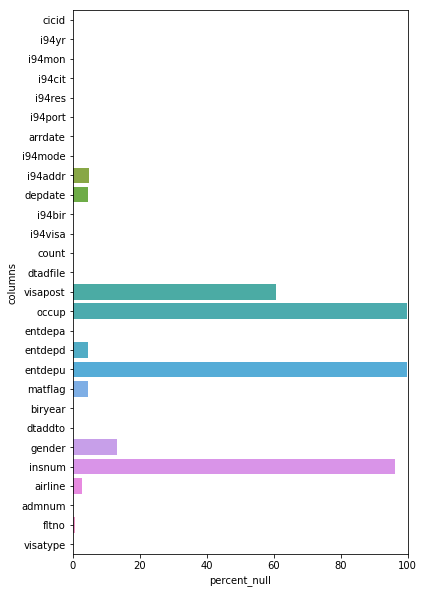

In [19]:
rcParams['figure.figsize'] = 6,10
ax=sns.barplot(y="columns", x="percent_null", data=null_df)
ax.set_xlim(0,100)

In [20]:
null_df_cities=check_null_values(df_cities)

(0, 100)

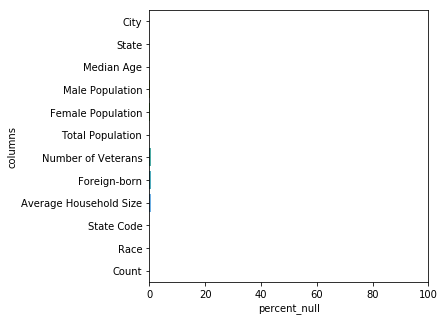

In [21]:
rcParams['figure.figsize'] = 5,5
ax=sns.barplot(y="columns", x="percent_null", data=null_df_cities)
ax.set_xlim(0,100)

In [23]:
null_df_codes=check_null_values(df_codes)

(0, 100)

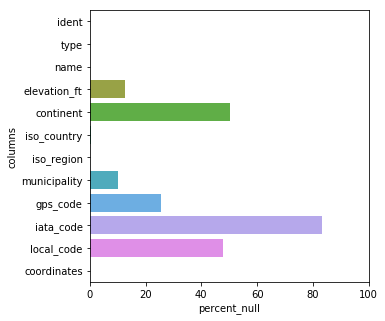

In [24]:
ax=sns.barplot(y="columns", x="percent_null", data=null_df_codes)
ax.set_xlim(0,100)

#### Cleaning Steps
Dropping columns that have high number of missing values

In [25]:
#select only necessary columns
cols_to_drop=["visapost","occup","entdepu","insnum"]
df_spark.drop(*cols_to_drop).take(1)

[Row(cicid=5748517.0, i94yr=2016.0, i94mon=4.0, i94cit=245.0, i94res=438.0, i94port='LOS', arrdate=20574.0, i94mode=1.0, i94addr='CA', depdate=20582.0, i94bir=40.0, i94visa=1.0, count=1.0, dtadfile='20160430', entdepa='G', entdepd='O', matflag='M', biryear=1976.0, dtaddto='10292016', gender='F', airline='QF', admnum=94953870030.0, fltno='00011', visatype='B1')]

In [27]:
#Drop rows with null values in the selected columns
df_valid=df_spark.dropna(subset=["airline","gender","matflag","entdepd","i94addr","depdate"])
df_valid.count()

2384935

In [28]:
df_spark.select(["visatype","i94visa"]).dropDuplicates().show()

+--------+-------+
|visatype|i94visa|
+--------+-------+
|      CP|    2.0|
|     CPL|    2.0|
|     GMB|    1.0|
|     SBP|    2.0|
|      B1|    1.0|
|       I|    1.0|
|      F2|    3.0|
|      E1|    1.0|
|      M2|    3.0|
|      WB|    1.0|
|      WT|    2.0|
|      E2|    1.0|
|      M1|    3.0|
|     GMT|    2.0|
|      B2|    2.0|
|      I1|    1.0|
|      F1|    3.0|
+--------+-------+



In [29]:
df_codes=df_codes.drop(["continent","local_code","gps_code"], axis=1)

In [30]:
df_codes_iata=df_codes[df_codes["iata_code"].notnull()]
df_codes_iata.head()

,ident,type,name,elevation_ft,iso_country,iso_region,municipality,iata_code,coordinates
223,03N,small_airport,Utirik Airport,4.0,MH,MH-UTI,Utirik Island,UTK,"169.852005, 11.222"
440,07FA,small_airport,Ocean Reef Club Airport,8.0,US,US-FL,Key Largo,OCA,"-80.274803161621, 25.325399398804"
594,0AK,small_airport,Pilot Station Airport,305.0,US,US-AK,Pilot Station,PQS,"-162.899994, 61.934601"
673,0CO2,small_airport,Crested Butte Airpark,8980.0,US,US-CO,Crested Butte,CSE,"-106.928341, 38.851918"
1088,0TE7,small_airport,LBJ Ranch Airport,1515.0,US,US-TX,Johnson City,JCY,"-98.62249755859999, 30.251800537100003"


In [31]:
df_codes[(df_codes.iata_code=="MIA")]

,ident,type,name,elevation_ft,iso_country,iso_region,municipality,iata_code,coordinates
28044,KMIA,large_airport,Miami International Airport,8.0,US,US-FL,Miami,MIA,"-80.29060363769531, 25.79319953918457"


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

After the cleaning operations above, we have the staging tables from which we create our fact table and the dimension tables
We have 3 staging tables from the 3 data sources
1. i94_immigration_data (df_spark) with columns () dropped and rows with null values dropped
2. US cities demographic data (df-cities) 
3. Airport codes data (df_codes) with columns () dropped 

We create the conceptual model as below with 1 fact table and 7 dimension tables as below :

Fact table - **i94_immigration table**
- cicid
- port
- arrdate
- deptdate
- visa type (foreign key to Visa table)
- count

Dimension tables
1. Date table
- Date
- Day
- Month
- Year

2. People table 
- cicid
- gender
- bir_year
- age
- i94cit
- i94res
- i94addr

3. Visa table
- visa_type
- visa_purpose

4. Airport codes
- iata_code
- name
- iso_region

5. US States demographics table (child table)
- median age
- total population
- state code

#### 3.2 Mapping Out Data Pipelines

The following are the steps needed to pipeline the data into the chosen model

1. Read the data from S3 the 4 different sources into the staging tables

2. Clean the data for missing values

3. Extract data that is relevant to the questions we need to answer -
    - select entries from immigration staging table that have i94mode=1
    - select entires from airport codes staging table that have country=US and iata_code is not NULL
    - select cicid, i94port, i94mon, arrdate, deptdate, visa_type, count from immigration table to form the Fact table
    - select visa_type and purpose from immigration table to from the visa dimension table
    - select the cicid, gender, bir_year, i94bir, i94cit, i94res, i94addr to create the i94 people dimention table
    - select iatacode, name and region from airport codes staging table to create the airport_codes dimension table 
    - select city, median age, state_code, total population from US cities demographics staging table to create the US states demographics dimension table
    - select the date entries from the immigration fact table and extract day, month, year from the date to create the date table     
    
4. Transform the data 
    - Convert the arrdate and dept date by addig the column values to 1960-1-1
    - Convert Median Age and Total Population columns in the cities demographics staging table to INT type.
    - Group the data from cities demographics table by the region/state code and take sum of the total population across cities in the state and take the avg of median age across cities in the state
    
5. Write the extracted and transformed data into parquet files back to S3
    - partition the i94 immigration table by port and month
    - partition the date table by year and month
    - partitiion the i94 people table by gender
    


#### Step 4: Run Pipelines to Model the Data
4.1 Create the data model
Build the data pipelines to create the data model.

In [3]:
#read_immigration
df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [18]:
#to read all files in the directory
import glob 
import os
path="../../data/18-83510-I94-Data-2016"
files=glob.glob(os.path.join(path,"*"))
for i,f in enumerate(files):
    df = spark.read.format('com.github.saurfang.sas.spark').load(f)     
    if i==0 :
        df_spark=df
        col_names=df.columns
    else:
        df_spark=df_spark.union(df[col_names])  

In [19]:
cols_to_drop=["visapost","occup","entdepu","insnum"]
df_spark=df_spark.drop(*cols_to_drop)
df_spark=df_spark.dropna(subset=["airline","gender","matflag","entdepd","i94addr","depdate"])
df_spark.count()

31205627

In [5]:
df_spark_valid=df_spark.select("cicid","i94port","i94mon","arrdate","depdate","i94mode", "visatype","count")

In [6]:
df_spark_valid=df_spark_valid.withColumn('new_arrival_date', expr("date_add('1960-1-1', arrdate)"))
df_spark_valid=df_spark_valid.withColumn('new_departure_date', expr("date_add('1960-1-1', depdate)"))

In [7]:
df_imm=df_spark_valid.filter(df_spark_valid["i94mode"]==1.0).drop("arrdate","depdate","i94mode")

In [8]:
df_imm.show(5)

+-----+-------+------+--------+-----+----------------+------------------+
|cicid|i94port|i94mon|visatype|count|new_arrival_date|new_departure_date|
+-----+-------+------+--------+-----+----------------+------------------+
| 15.0|    WAS|   4.0|      B2|  1.0|      2016-04-01|        2016-08-25|
| 27.0|    BOS|   4.0|      B1|  1.0|      2016-04-01|        2016-04-05|
| 28.0|    ATL|   4.0|      B1|  1.0|      2016-04-01|        2016-04-05|
| 29.0|    ATL|   4.0|      B2|  1.0|      2016-04-01|        2016-04-17|
| 30.0|    ATL|   4.0|      B2|  1.0|      2016-04-01|        2016-05-04|
+-----+-------+------+--------+-----+----------------+------------------+
only showing top 5 rows



In [9]:
df_imm.write.partitionBy('i94port','i94mon').mode('overwrite').parquet("imm")

In [10]:
df_ppl=df_spark.select("cicid","i94res", "i94cit", "gender","i94bir","biryear","i94addr")

In [8]:
df_ppl.show(5)

+-----+------+------+------+------+-------+-------+
|cicid|i94res|i94cit|gender|i94bir|biryear|i94addr|
+-----+------+------+------+------+-------+-------+
| 15.0| 101.0| 101.0|     M|  55.0| 1961.0|     MI|
| 27.0| 101.0| 101.0|     M|  58.0| 1958.0|     MA|
| 28.0| 101.0| 101.0|     F|  56.0| 1960.0|     MA|
| 29.0| 101.0| 101.0|     M|  62.0| 1954.0|     MA|
| 30.0| 101.0| 101.0|     M|  49.0| 1967.0|     NJ|
+-----+------+------+------+------+-------+-------+
only showing top 5 rows



In [11]:
df_ppl.write.partitionBy('gender').mode('overwrite').parquet("imm_ppl")

In [12]:
df_visa=df_spark.select("visatype", "i94visa").dropDuplicates()

In [13]:
df_visa.show()

+--------+-------+
|visatype|i94visa|
+--------+-------+
|      CP|    2.0|
|     CPL|    2.0|
|     GMB|    1.0|
|     SBP|    2.0|
|      B1|    1.0|
|       I|    1.0|
|      F2|    3.0|
|      E1|    1.0|
|      M2|    3.0|
|      WB|    1.0|
|      WT|    2.0|
|      E2|    1.0|
|      M1|    3.0|
|     GMT|    2.0|
|      B2|    2.0|
|      I1|    1.0|
|      F1|    3.0|
+--------+-------+



In [46]:
df_visa.write.mode('overwrite').parquet("visa")

In [14]:
df_time=df_imm.select("new_arrival_date").dropDuplicates()\
             .withColumn('Day', dayofmonth('new_arrival_date'))\
             .withColumn('Month', month('new_arrival_date'))\
             .withColumn('Year', year('new_arrival_date')).withColumnRenamed("new_arrival_date","Date")

In [15]:
df_time.show()

+----------+---+-----+----+
|      Date|Day|Month|Year|
+----------+---+-----+----+
|2016-04-25| 25|    4|2016|
|2016-04-22| 22|    4|2016|
|2016-04-30| 30|    4|2016|
|2016-04-26| 26|    4|2016|
|2016-04-04|  4|    4|2016|
|2016-04-16| 16|    4|2016|
|2016-04-18| 18|    4|2016|
|2016-04-11| 11|    4|2016|
|2016-04-29| 29|    4|2016|
|2016-04-19| 19|    4|2016|
|2016-04-14| 14|    4|2016|
|2016-04-08|  8|    4|2016|
|2016-04-02|  2|    4|2016|
|2016-04-20| 20|    4|2016|
|2016-04-13| 13|    4|2016|
|2016-04-09|  9|    4|2016|
|2016-04-17| 17|    4|2016|
|2016-04-01|  1|    4|2016|
|2016-04-07|  7|    4|2016|
|2016-04-12| 12|    4|2016|
+----------+---+-----+----+
only showing top 20 rows



In [48]:
df_time.write.partitionBy('Year','Month').mode('overwrite').parquet("time")

In [49]:
#read_airport_codes
path_codes="airport-codes_csv.csv"
df_spark_codes=spark.read.csv(path_codes, header=True)
df_spark_codes.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [50]:
df_codes=df_spark_codes.select("type","name","iso_region","iata_code")\
                    .filter((df_spark_codes["iata_code"]!="null") & (df_spark_codes["iso_country"]=="US"))\
                    .filter((df_spark_codes['type']== "large_airport"))\
                    .drop("iso_country", "type")
df_codes.show(5)

+--------------------+----------+---------+
|                name|iso_region|iata_code|
+--------------------+----------+---------+
|Albuquerque Inter...|     US-NM|      ABQ|
|  Joint Base Andrews|     US-MD|      ADW|
|Fort Worth Allian...|     US-TX|      AFW|
|Augusta Regional ...|     US-GA|      AGS|
|Rick Husband Amar...|     US-TX|      AMA|
+--------------------+----------+---------+
only showing top 5 rows



In [51]:
df_codes.write.mode('overwrite').parquet("AirportCodes")

In [52]:
#read_cities_demo
path_cities = "us-cities-demographics.csv"
df_spark_cities=spark.read.option("delimiter",";").csv(path_cities, header=True)
df_spark_cities.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



In [53]:
df_spark_cities=df_spark_cities.withColumn("Median Age",df_spark_cities['Median Age'].cast('int'))
df_spark_cities=df_spark_cities.withColumn("Total Population",df_spark_cities['Total Population'].cast('int'))

In [55]:
df_states = df_spark_cities.select("City","Median Age","State Code", "Total Population").dropDuplicates()\
                       .groupby("State Code").agg(\
                                            f.sum("Total Population").alias("Population"),\
                                            avg("Median Age").alias("Median_age") )\
                       .withColumn("new", concat(lit("US-"),df_spark_cities['State Code']))\
                       .drop("State Code").withColumnRenamed("new","State_Code")
df_states.show(5)

+----------+------------------+----------+
|Population|        Median_age|State_Code|
+----------+------------------+----------+
|    533657|              33.8|     US-SC|
|   4499542|           34.4375|     US-AZ|
|   1300595|              34.0|     US-LA|
|   1422403| 35.09090909090909|     US-MN|
|   1428908|34.666666666666664|     US-NJ|
+----------+------------------+----------+
only showing top 5 rows



In [56]:
df_states.write.mode('overwrite').parquet("US_States_demographics")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [57]:
df_states.dtypes

[('Population', 'bigint'), ('Median_age', 'double'), ('State_Code', 'string')]

In [58]:
df_imm.dtypes

[('cicid', 'double'),
 ('i94port', 'string'),
 ('i94mon', 'double'),
 ('visatype', 'string'),
 ('count', 'double'),
 ('new_arrival_date', 'date'),
 ('new_departure_date', 'date')]

In [59]:
df_codes.dtypes

[('name', 'string'), ('iso_region', 'string'), ('iata_code', 'string')]

In [60]:
df_time.dtypes

[('Date', 'date'), ('Day', 'int'), ('Month', 'int'), ('Year', 'int')]

In [61]:
df_visa.dtypes

[('visatype', 'string'), ('i94visa', 'double')]

In [62]:
df_ppl.dtypes

[('cicid', 'double'),
 ('i94res', 'double'),
 ('i94cit', 'double'),
 ('gender', 'string'),
 ('i94bir', 'double'),
 ('biryear', 'double'),
 ('i94addr', 'string')]

In [63]:
df_top=df_imm.groupBy("i94port").agg(f.sum('count').alias("total")).sort(desc("total"))
df_top.show(3)

+-------+---------+
|i94port|    total|
+-------+---------+
|    NYC|6653688.0|
|    MIA|5080114.0|
|    LOS|4601366.0|
+-------+---------+
only showing top 3 rows



In [64]:
#for ports in airport codes table which have an iata code
df_top.join(df_codes, df_top.i94port == df_codes.iata_code).sort(desc("total")).select("i94port","iso_region","total").show(3)

+-------+----------+---------+
|i94port|iso_region|    total|
+-------+----------+---------+
|    MIA|     US-FL|5080114.0|
|    HOU|     US-TX|1333149.0|
|    ATL|     US-GA|1140956.0|
+-------+----------+---------+
only showing top 3 rows



In [17]:
df_imm.join(df_ppl, df_imm.cicid == df_ppl.cicid).filter((df_imm["i94port"]=="MIA") &(df_imm['i94mon']=='4')).groupBy("gender").sum("count").show()

+------+----------+
|gender|sum(count)|
+------+----------+
|     F|  139409.0|
|     M|  137161.0|
|     U|       2.0|
|     X|       2.0|
+------+----------+



#### 4.3 Data dictionary 
DataDictionary.md in the repository

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.